In [37]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import stats, spatial
import pickle
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)
import csv
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar


In [59]:
tfidf_path = '../../data/tfidf_merged_chs_20210915_no_crossover/'

In [39]:
lda_path = '../../data/lda_merged_chs_20210915_no_crossover/'

In [40]:
# fandom_list = [i for i in os.listdir(lda_path) if 'tsv' in i]

In [41]:
# fandom_list

In [42]:
# df = pd.read_csv(os.path.join(lda_path,'sherlock_holmes_&_related_fandoms_temporal_lda_jsd_toprev_with_dist_merged_chs_no_text.tsv'), sep = '\t')

In [43]:
# len(df)

In [44]:
def var_bootstrap_resample(li):
    if len(li) > 0:
        var_original = np.var(li)
        var_s = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            var_s.append(np.var(sample))
        tail = sorted(var_s)[5]
        head = sorted(var_s)[95]
        return (var_original, tail, head)

In [45]:
def ave_bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        ave_s = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            ave_s.append(np.average(sample))
        tail = sorted(ave_s)[5]
        head = sorted(ave_s)[95]
        return (ave_original, tail, head)

In [46]:
def normalize_dfs(df):
    
    # normalization of the success field
    df = df.replace([np.inf, -np.inf], np.nan)
    df['Hits'].fillna(0, inplace=True)
    df['Kudos'].fillna(0, inplace=True)
    df['Bookmarks'].fillna(0, inplace=True)
    df['Comments'].fillna(0, inplace=True)

    # normalize by chapter number
    df['Kudos'] = df['Kudos']/df['Chapters'] 
    df = df.replace([np.inf, -np.inf], np.nan)
    df['Kudos'].dropna()

    df['Hits'] = df['Hits']/df['Chapters']
    df = df.replace([np.inf, -np.inf], np.nan)
    df['Hits'].dropna()

    df['Bookmarks'] = df['Bookmarks']/df['Chapters']
    df = df.replace([np.inf, -np.inf], np.nan)
    df['Bookmarks'].dropna()
    return df

In [47]:
def create_dict(df, nov_field, suc_field, metric):
    
    # Make bins
    df[nov_field] = df[nov_field].astype(float)
    term_n = sorted(df[nov_field].tolist())
    term_n = np.quantile(term_n, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    term_n = np.insert(term_n, 0, 0)
    term_n = np.concatenate([term_n, [1]])
    dic = {}
    for i in range(len(term_n)-1):
        df_s = df[(df[nov_field] >= term_n[i]) & (df[nov_field] < term_n[i+1])]
        li = df_s[suc_field].tolist()
        if len(li) > 0:
            if metric == 'ave':
                dic[term_n[i]] = ave_bootstrap_resample(li)
            elif metric == 'var':
                dic[term_n[i]] = var_bootstrap_resample(li)
    return dic

In [48]:
def generate_res(path, fandom, nov_field, suc_field, metric):
    if nov_field == 'Cos':
        df = pd.read_csv(os.path.join(path,fandom + \
                                  '_temporal_tfidf_cos_merged_chapters_no_crossover_no_sample_20210915.tsv'), sep = '\t')
    elif nov_field == 'JSD':
        df = pd.read_csv(os.path.join(path,fandom + \
                                  '_lda_with_dist_merged_chs_no_crossover_20210915.tsv'), sep = '\t')
        
    df = normalize_dfs(df)
    df = df[df.Hits >= 10]
    df['kudos_hist_ratio'] = df['Kudos']/df['Hits']  
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df[[nov_field, suc_field]].dropna()

#     df = df.sort_values(by = nov_field)
#     df = df.sort_values(by = suc_field)
    dic = create_dict(df, nov_field, suc_field, metric)
    
    top_5p = np.percentile(df[suc_field], 95)
    df_top5p = df[df[suc_field] > top_5p]
    dic_top5p = create_dict(df_top5p, nov_field, suc_field, metric)
    
    bot_5p = np.percentile(df[suc_field], 5)
    df_bot5p = df[df[suc_field] < bot_5p]
    dic_bot5p = create_dict(df_bot5p, nov_field, suc_field, metric)

    return dic, dic_top5p, dic_bot5p
    

In [49]:
def generate_dics(fandom, suffix='None'):
    tfidf_kudos_dict_var, tfidf_kudos_dict_var_top5p, tfidf_kudos_dict_var_bot5p = generate_res(tfidf_path, fandom, 'Cos', 'kudos_hist_ratio', 'var')

    tfidf_kudos_dict_ave, tfidf_kudos_dict_ave_top5p, tfidf_kudos_dict_ave_bot5p = generate_res(tfidf_path,  fandom,'Cos', 'kudos_hist_ratio', 'ave')
    
    lda_kudos_dict_var, lda_kudos_dict_var_top5p, lda_kudos_dict_var_bot5p = generate_res(lda_path, fandom, 'JSD', 'kudos_hist_ratio', 'var')

    lda_kudos_dict_ave, lda_kudos_dict_ave_top5p, lda_kudos_dict_ave_bot5p = generate_res(lda_path, fandom, 'JSD', 'kudos_hist_ratio', 'ave')

    
    return tfidf_kudos_dict_var, tfidf_kudos_dict_var_top5p, tfidf_kudos_dict_var_bot5p,\
            tfidf_kudos_dict_ave, tfidf_kudos_dict_ave_top5p, tfidf_kudos_dict_ave_bot5p,\
            lda_kudos_dict_var, lda_kudos_dict_var_top5p, lda_kudos_dict_var_bot5p, \
            lda_kudos_dict_ave, lda_kudos_dict_ave_top5p, lda_kudos_dict_ave_bot5p 

In [50]:
def create_xs(keys):
    xs = []
    for i in range(len(keys)-1):
        xs.append(keys[i] + (keys[i+1] - keys[i])/2)
    return xs

In [51]:
def extract_plot_vals(dic):
    keys = sorted(dic.keys())
    keys.append(1)
    x = create_xs(keys)
    y = [dic[j][0] for j in keys[:-1]]
    lower_error = [dic[j][0] - dic[j][1] for j in keys[:-1]]
    upper_error = [dic[j][2] - dic[j][0] for j in keys[:-1]]
    asymmetric_error = [lower_error, upper_error]
    return x,y,asymmetric_error

In [57]:
fandom_list = ['harry_potter',
 'dcu',
 'doctor_who_&_related_fandoms',
 'star_wars_all_media_types',
 'arthurian_mythology_&_related_fandoms',
 'supernatural',
 'haikyuu',
 'kuroko_no_basuke',
 'hamilton_miranda',
 'dragon_age_all_media_types',
 'the_walking_dead_&_related_fandoms',
 'buffy_the_vampire_slayer',
 'naruto',
 'tolkien_j_r_r_works_&_related_fandoms',
 'shakespare_william_works',
 'hetalia_axis_powers',
 'attack_on_titan',
 'ms_paint_adventures',
 'marvel',
 'bishoujo_senshi_sailor_moon',
 'one_direction',
 'sherlock_holmes_&_related_fandoms']

harry_potter


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


dcu
doctor_who_&_related_fandoms
star_wars_all_media_types
arthurian_mythology_&_related_fandoms
supernatural
haikyuu
kuroko_no_basuke
hamilton_miranda
dragon_age_all_media_types
the_walking_dead_&_related_fandoms
buffy_the_vampire_slayer
couldn't plot fandom
naruto
tolkien_j_r_r_works_&_related_fandoms
shakespare_william_works
hetalia_axis_powers
attack_on_titan
ms_paint_adventures
marvel
bishoujo_senshi_sailor_moon
one_direction
sherlock_holmes_&_related_fandoms


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


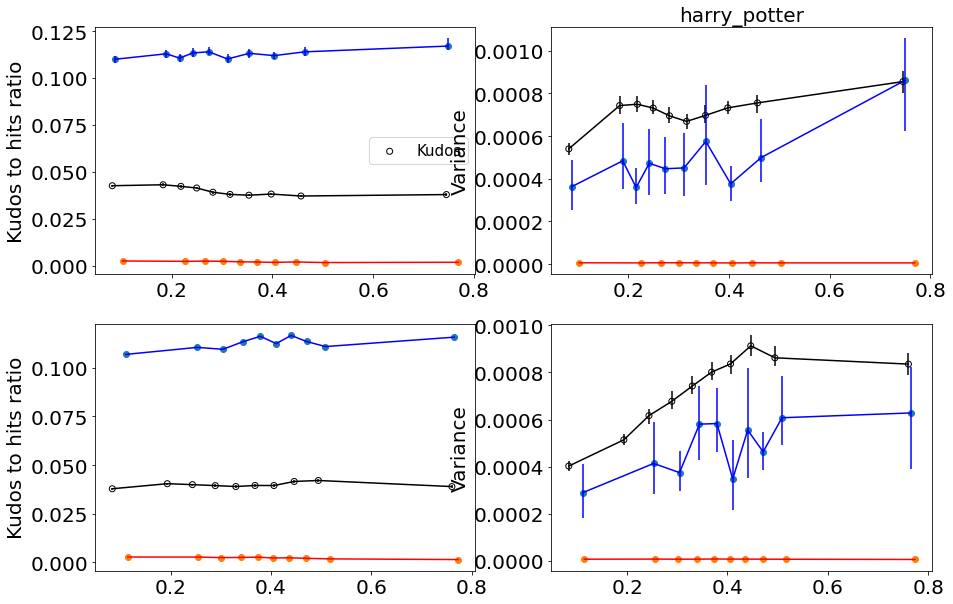

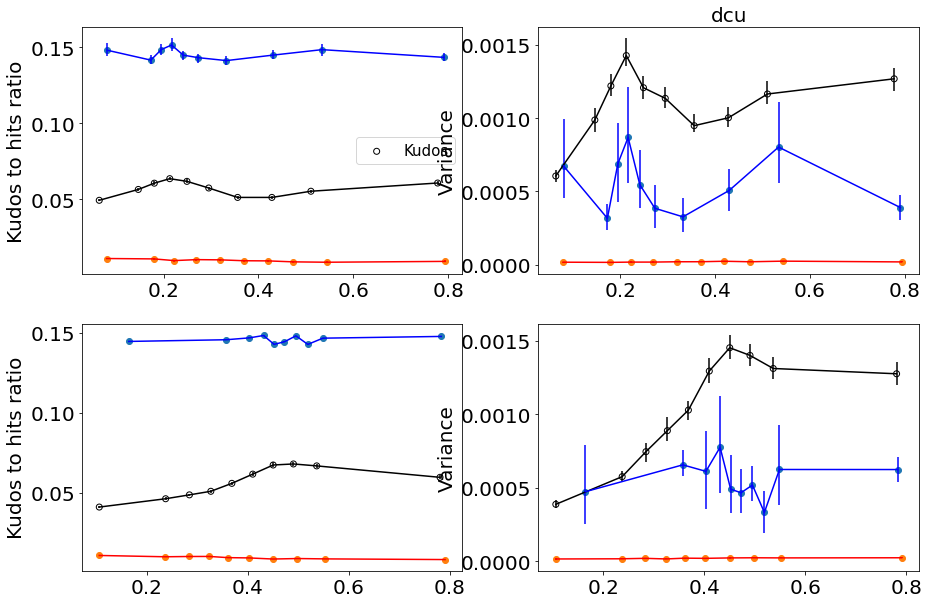

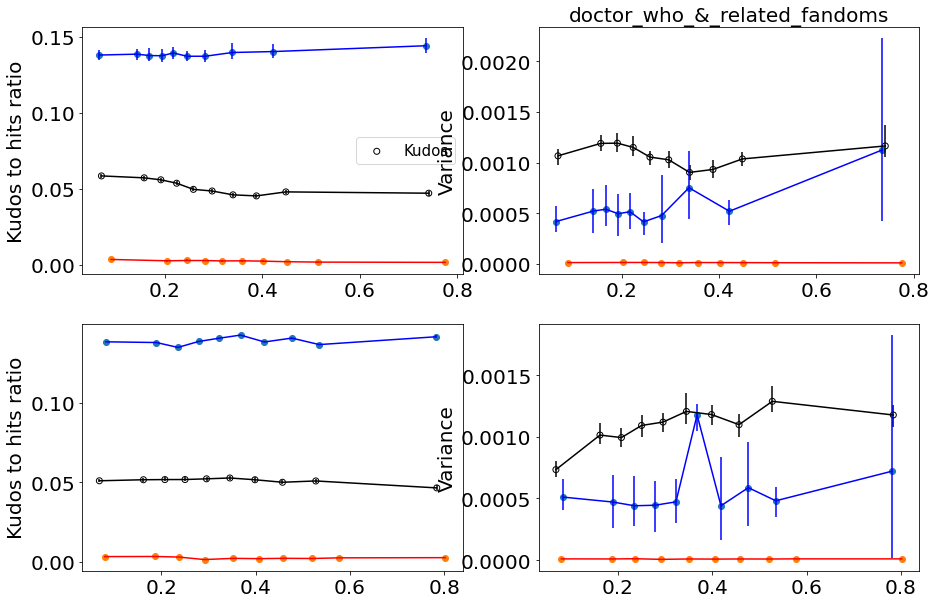

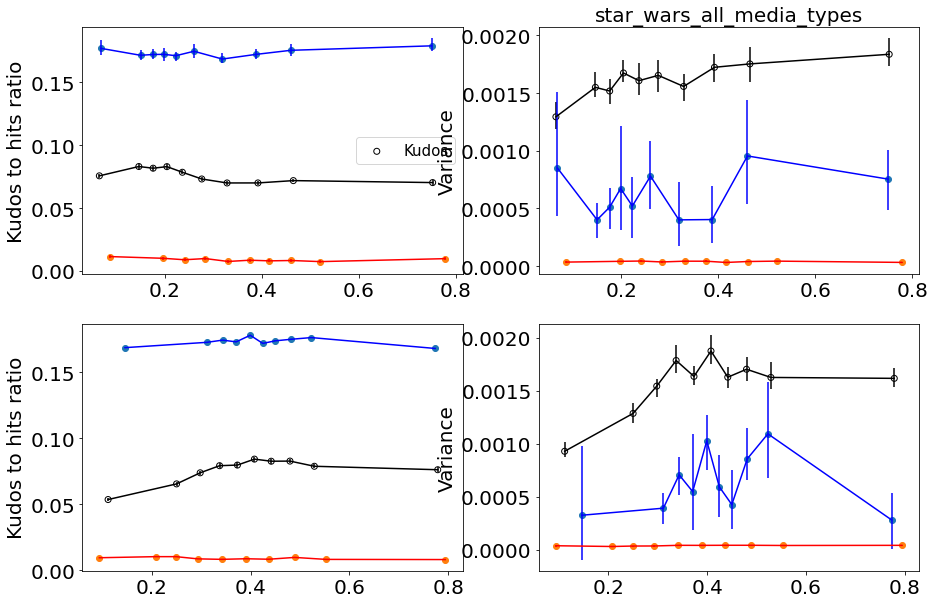

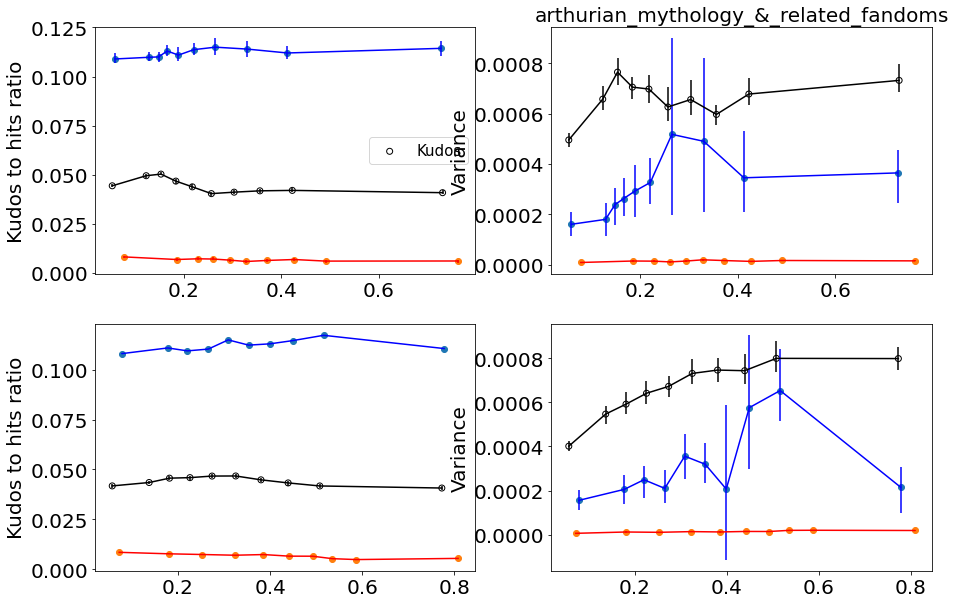

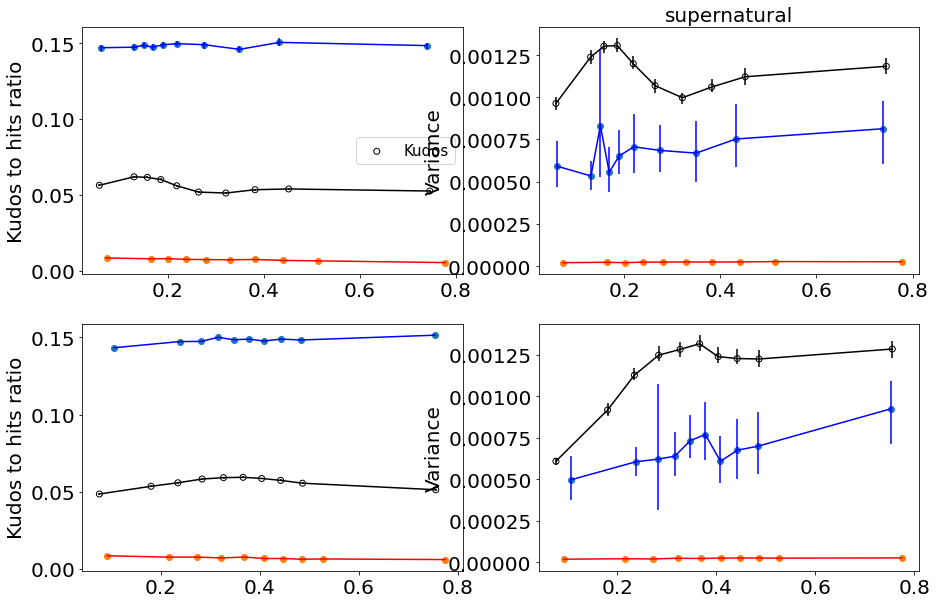

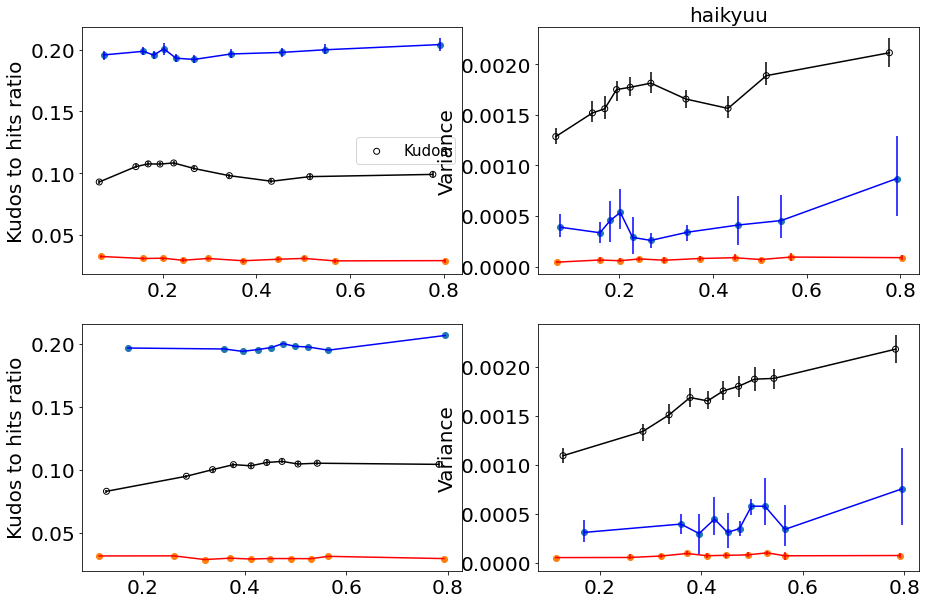

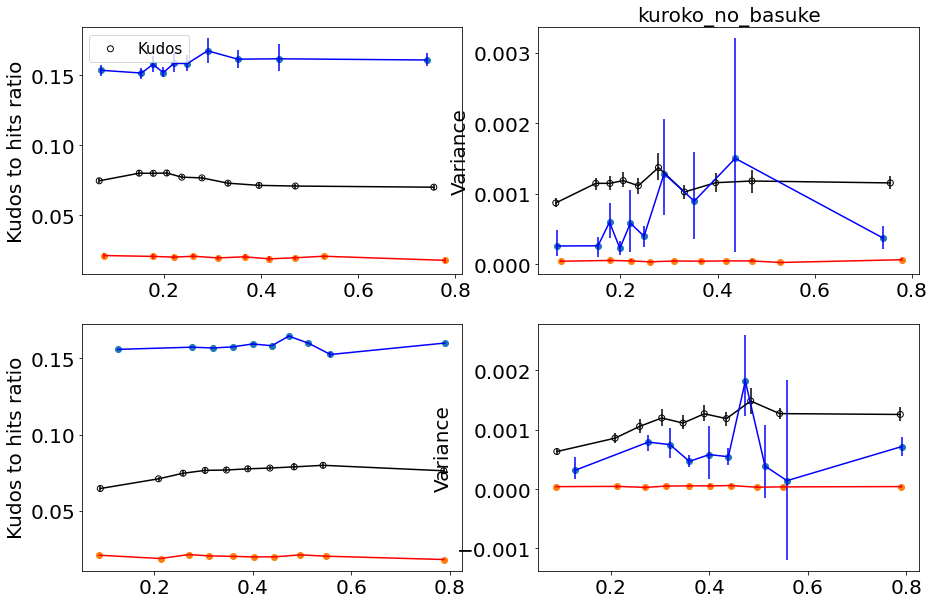

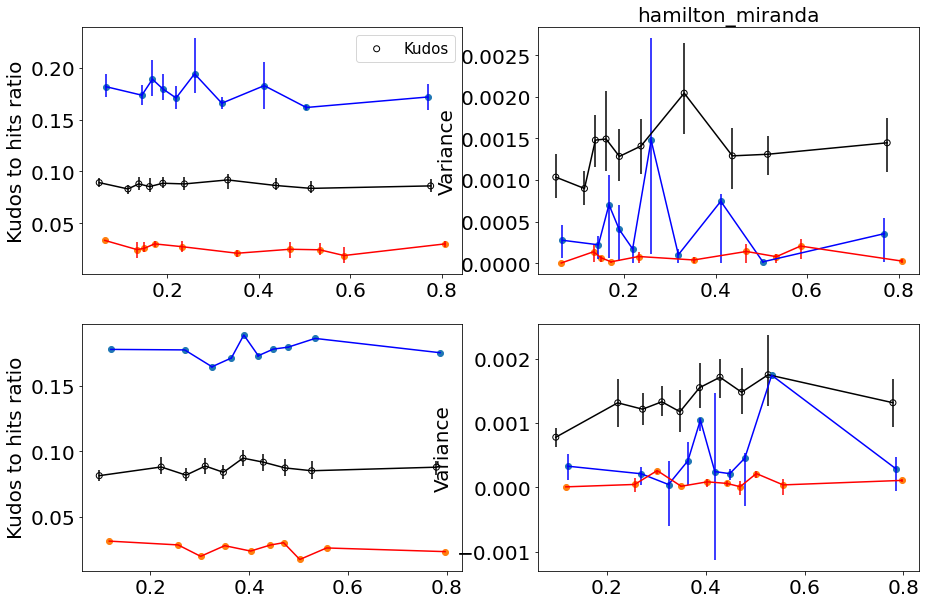

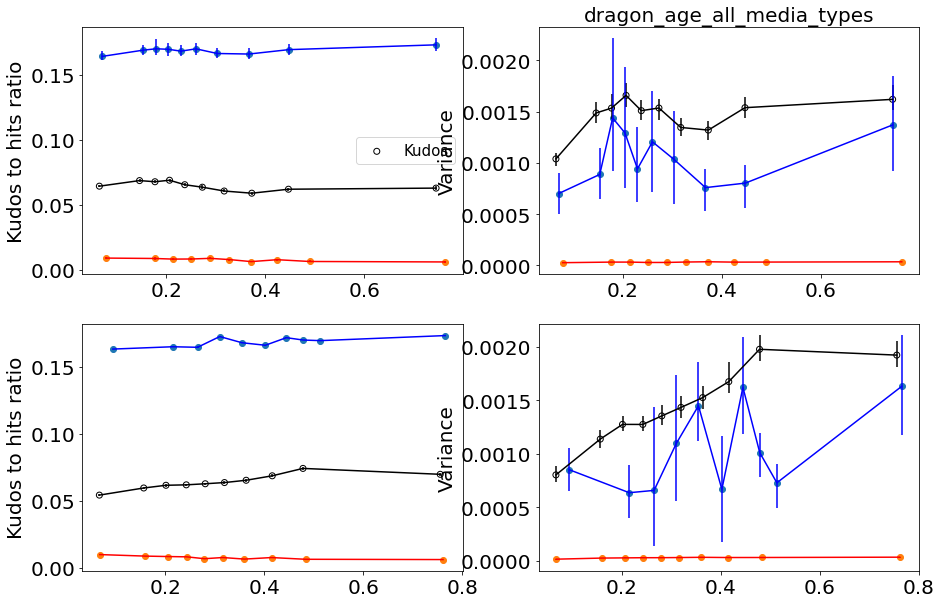

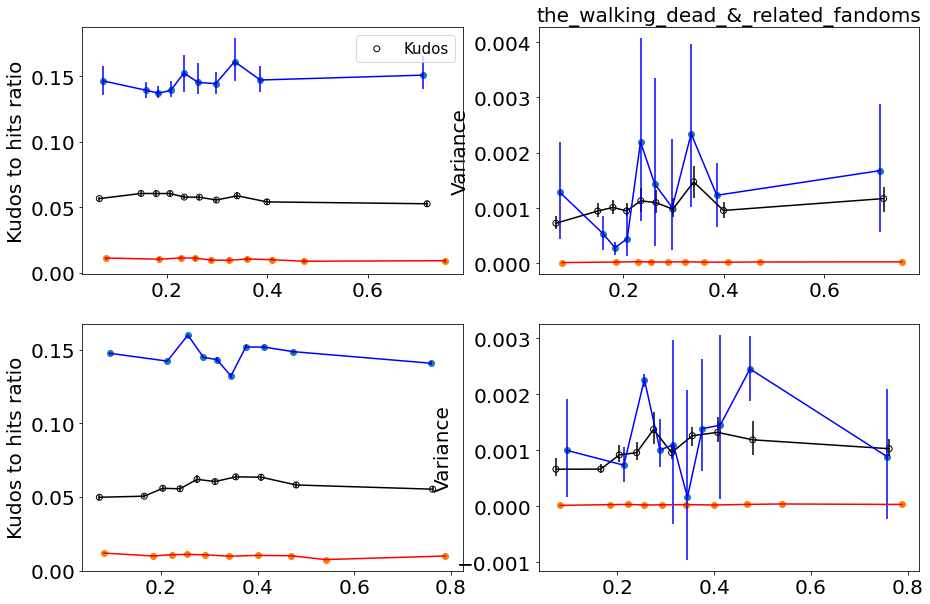

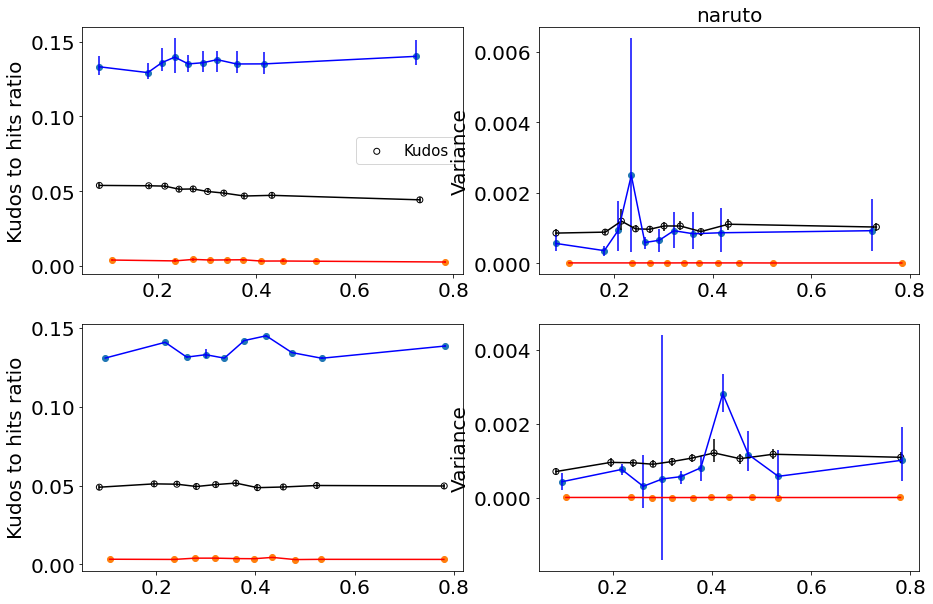

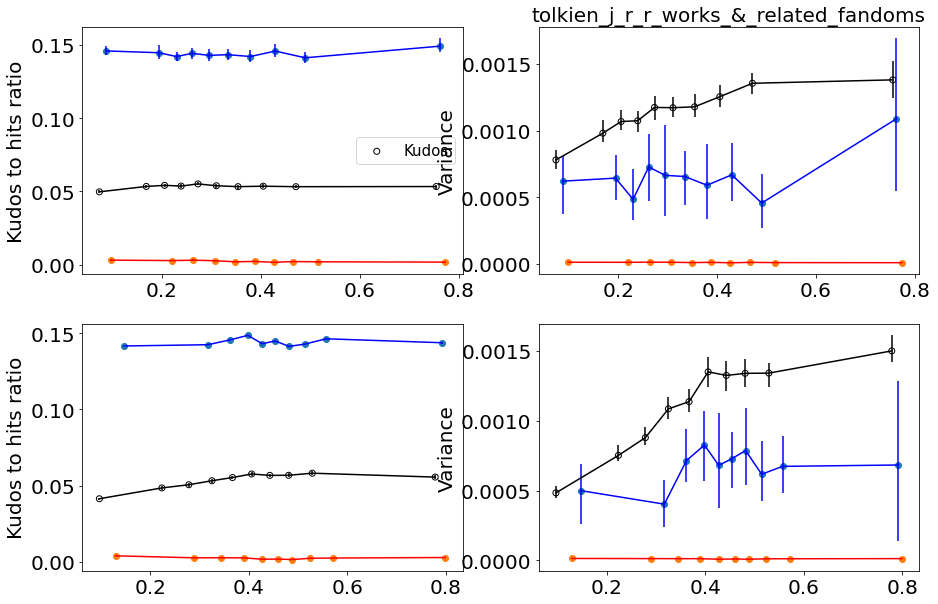

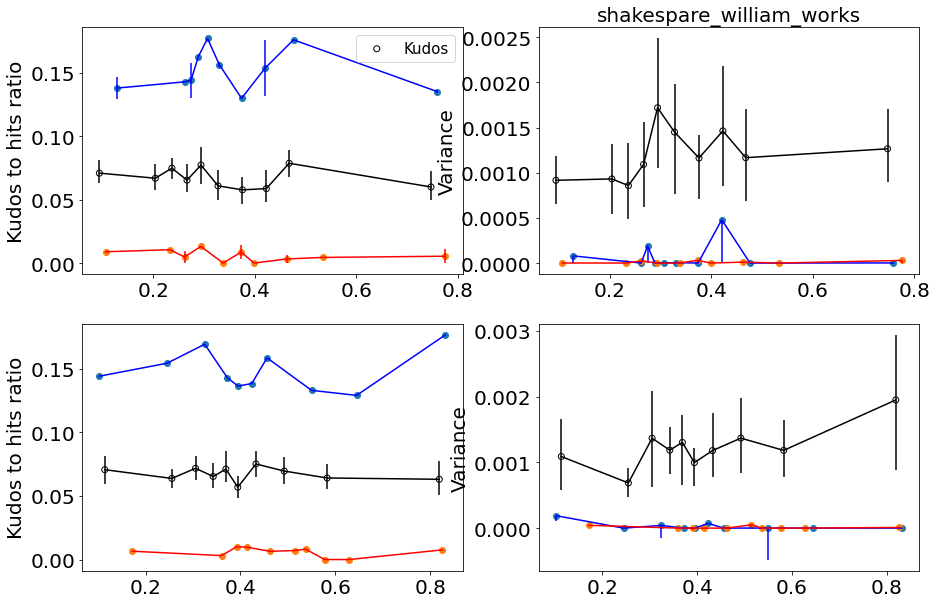

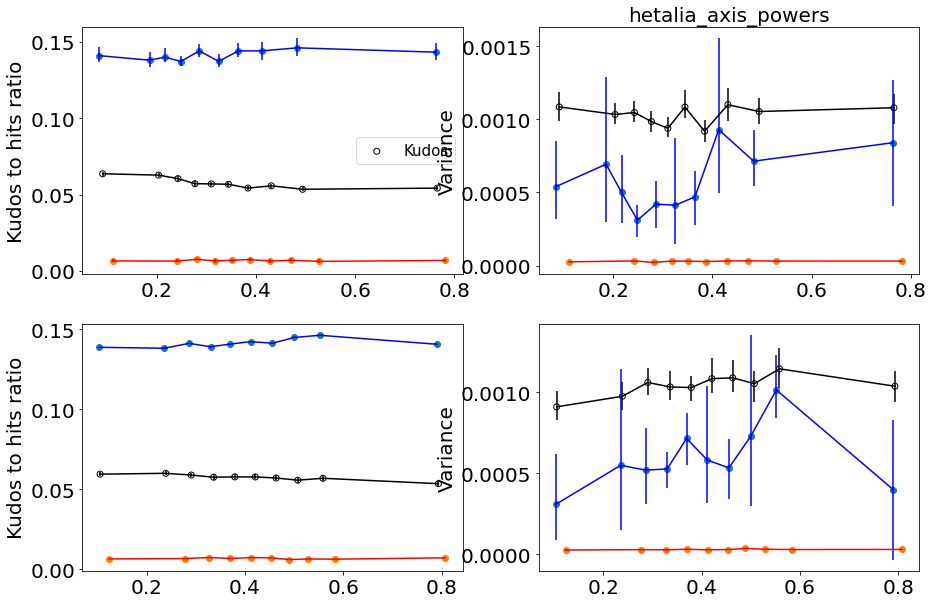

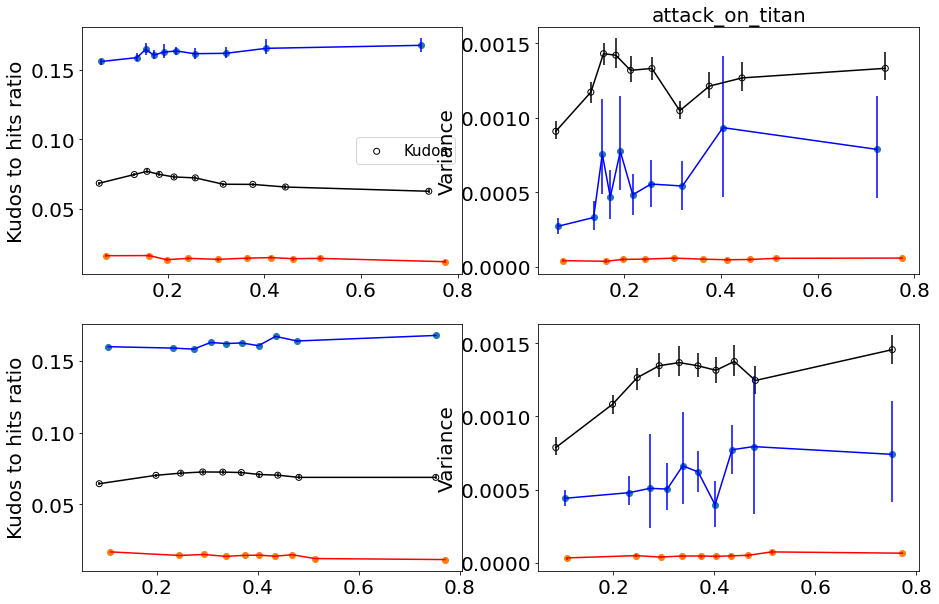

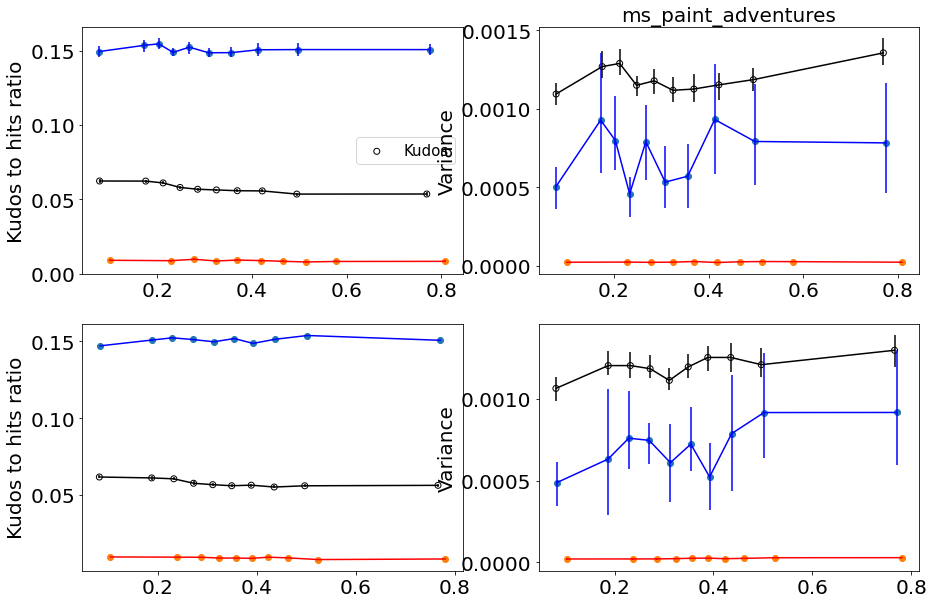

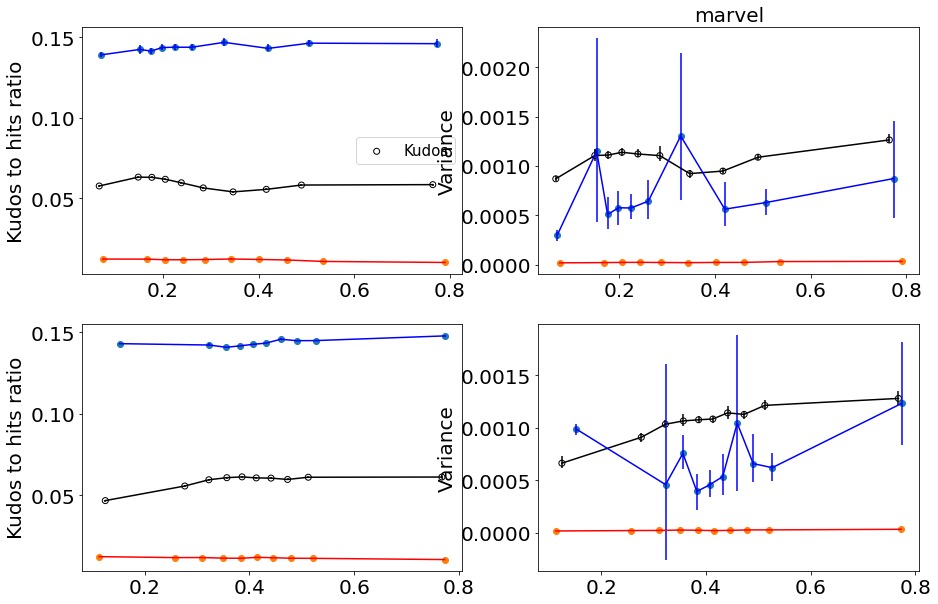

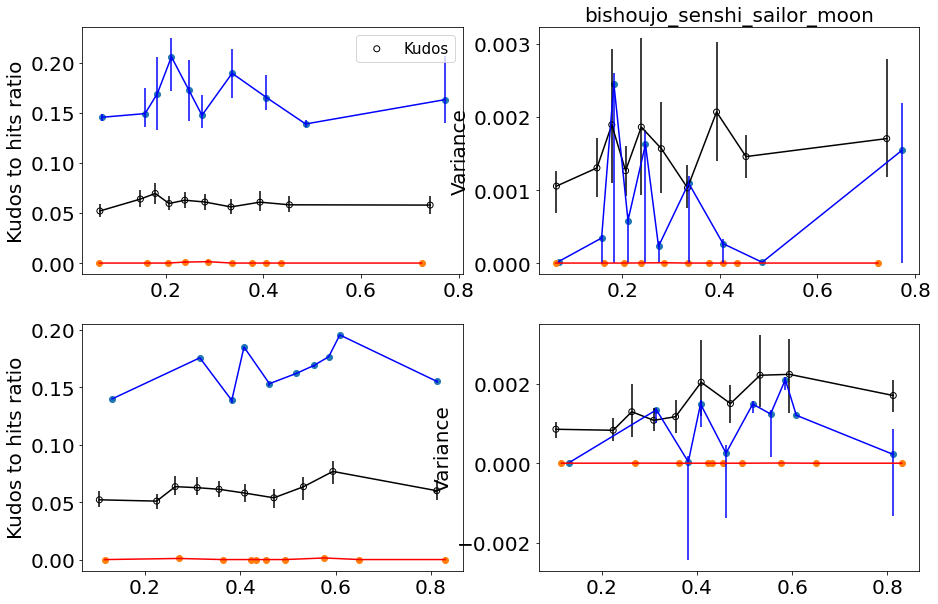

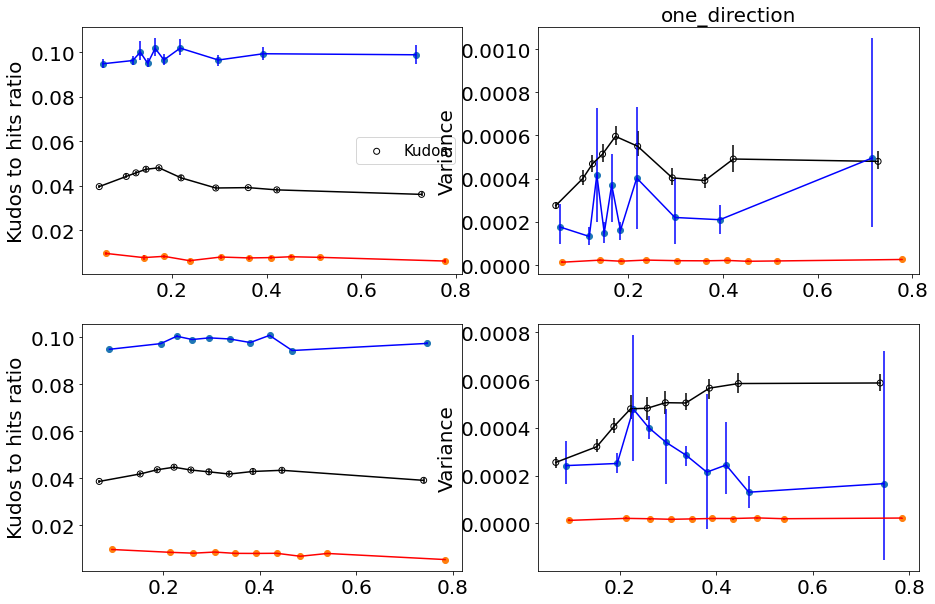

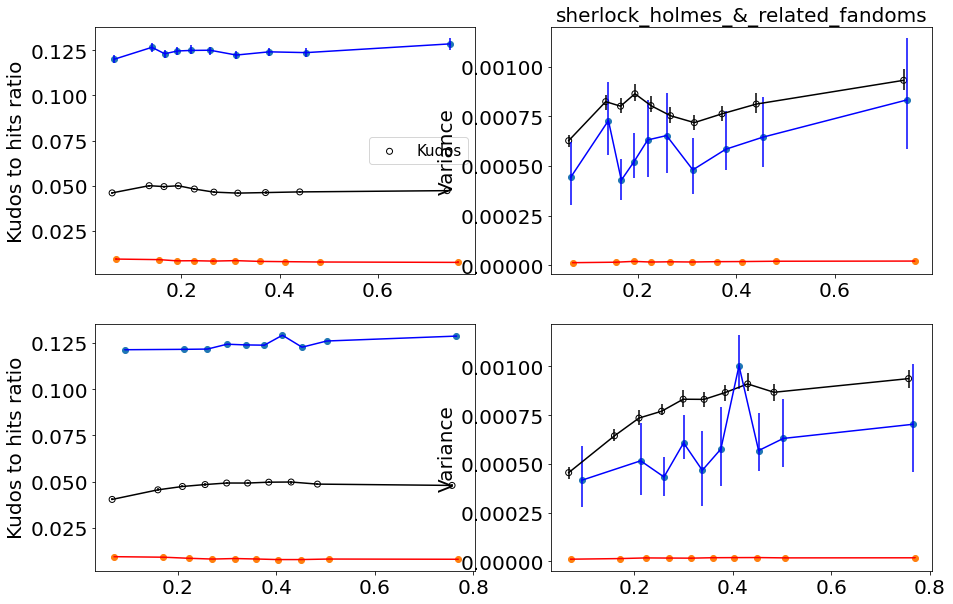

In [63]:
for fandom in fandom_list:
    print(fandom)
    try:
        tfidf_kudos_dict_var, tfidf_kudos_dict_var_top5p, tfidf_kudos_dict_var_bot5p,\
        tfidf_kudos_dict_ave, tfidf_kudos_dict_ave_top5p, tfidf_kudos_dict_ave_bot5p,\
        lda_kudos_dict_var, lda_kudos_dict_var_top5p, lda_kudos_dict_var_bot5p, \
        lda_kudos_dict_ave, lda_kudos_dict_ave_top5p, lda_kudos_dict_ave_bot5p =  generate_dics(fandom)

        fig, axes = plt.subplots(2,2,figsize = (15,10))

        #################subplot 1################
        x, y, err = extract_plot_vals(tfidf_kudos_dict_ave)
        axes[0][0].errorbar(x, y, yerr=err, color='black')
        axes[0][0].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

        x_top5p, y_top5p, err_top5p = extract_plot_vals(tfidf_kudos_dict_ave_top5p)
        axes[0][0].errorbar(x_top5p, y_top5p, yerr=err_top5p, color='blue')
        axes[0][0].scatter(x_top5p, y_top5p)  

        x_bot5p, y_bot5p, err_bot5p = extract_plot_vals(tfidf_kudos_dict_ave_bot5p)
        axes[0][0].errorbar(x_bot5p, y_bot5p, yerr=err_bot5p, color='red')
        axes[0][0].scatter(x_bot5p, y_bot5p)

        axes[0][0].legend(prop={'size': 15})
        axes[0][0].set_ylabel('Kudos to hits ratio',fontsize=20)
        axes[0][0].tick_params(labelsize=20)


        #################subplot 2################

        x, y, err = extract_plot_vals(tfidf_kudos_dict_var)
        axes[0][1].errorbar(x, y, yerr=err, color='black')
        axes[0][1].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

        x_top5p, y_top5p, err_top5p = extract_plot_vals(tfidf_kudos_dict_var_top5p)
        axes[0][1].errorbar(x_top5p, y_top5p, yerr=err_top5p, color='blue')
        axes[0][1].scatter(x_top5p, y_top5p)

        x_bot5p, y_bot5p, err_bot5p = extract_plot_vals(tfidf_kudos_dict_var_bot5p)
        axes[0][1].errorbar(x_bot5p, y_bot5p, yerr=err_bot5p, color='red')
        axes[0][1].scatter(x_bot5p, y_bot5p)

        axes[0][1].set_ylabel('Variance',fontsize=20)
        # plt.legend()
        axes[0][1].tick_params(labelsize=20)
        axes[0][1].set_title(fandom, fontsize=20)

        #################subplot 3################

        x, y, err = extract_plot_vals(lda_kudos_dict_ave)
        axes[1][0].errorbar(x, y, yerr=err, color='black')
        axes[1][0].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

        x_top5p, y_top5p, _ = extract_plot_vals(lda_kudos_dict_ave_top5p)
        axes[1][0].errorbar(x_top5p, y_top5p, yerr=err_top5p, color='blue')
        axes[1][0].scatter(x_top5p, y_top5p)    

        x_bot5p, y_bot5p, _ = extract_plot_vals(lda_kudos_dict_ave_bot5p)
        axes[1][0].errorbar(x_bot5p, y_bot5p, yerr=err_bot5p, color='red')
        axes[1][0].scatter(x_bot5p, y_bot5p)

        # plt.legend(prop={'size': 15})
        axes[1][0].set_ylabel('Kudos to hits ratio',fontsize=20)
        axes[1][0].tick_params(labelsize=20)

        #################subplot 4################

        x, y, err = extract_plot_vals(lda_kudos_dict_var)
        axes[1][1].errorbar(x, y, yerr=err, color='black')
        axes[1][1].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

        x_top5p, y_top5p, _ = extract_plot_vals(lda_kudos_dict_var_top5p)
        axes[1][1].errorbar(x_top5p, y_top5p, yerr=err_top5p, color='blue')
        axes[1][1].scatter(x_top5p, y_top5p) 

        x_bot5p, y_bot5p, _ = extract_plot_vals(lda_kudos_dict_var_bot5p)
        axes[1][1].errorbar(x_bot5p, y_bot5p, yerr=err_bot5p, color='red')
        axes[1][1].scatter(x_bot5p, y_bot5p)

        axes[1][1].set_ylabel('Variance',fontsize=20)
        axes[1][1].tick_params(labelsize=20)
    except:
        print('couldn\'t plot fandom')


In [ ]:
harry_potter_temporal_tfidf_cos_merged_chapters_no_crossover_no_sample_20210915.tsv